In [1]:
import sys
sys.path.insert(0, "..")

# MTCNN ONet

This notebook demonstrates the ONet architecture and its corresponding weights.

ONet is a fully convolutional neural network (CNN) used in the third and final stage of MTCNN. This network further refines the bounding box proposals generated by the previous RNet stage and adds facial landmark detection. It produces three outputs:

* Regression of the bounding box coordinates to fine-tune the proposals.
* Classification of the proposals into two categories: no-face or face.
* Detection of five facial landmarks (eyes, nose, and mouth corners).

The outputs are generated for each bounding box proposal, providing more precise detections and facial landmarks.

In the following sections, we will run the MTCNN model, focusing solely on the ONet stage. We will examine the intermediate inputs, observe the output shapes, and visualize the results.

## MTCNN on ONet Stage

MTCNN can be configured to run up to the third stage, which will provide the direct output of the ONet stage, including refined bounding boxes and facial landmarks.


In [2]:
from mtcnn import MTCNN
from mtcnn.utils.images import load_image
from mtcnn.stages import StagePNet, StageRNet, StageONet

2024-10-07 10:22:05.056123: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 10:22:05.066533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 10:22:05.078993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 10:22:05.082641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 10:22:05.092892: I tensorflow/core/platform/cpu_feature_guar

In [3]:
image = load_image("../resources/ivan.jpg")

2024-10-07 10:22:06.564155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46865 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-10-07 10:22:06.564560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7527 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:17:00.0, compute capability: 6.1


In [4]:
# This is the default configuration of stages, aliased as "face_and_landmarks_detection"
mtcnn = MTCNN(stages=[StagePNet, StageRNet, StageONet], device="CPU:0")

In [5]:
%%time
result = mtcnn.detect_faces(image, postprocess=True, threshold_onet=0.85)

CPU times: user 653 ms, sys: 230 ms, total: 883 ms
Wall time: 473 ms


In [6]:
result

[{'box': [276, 92, 50, 63],
  'confidence': 0.9999972581863403,
  'keypoints': {'nose': [304, 131],
   'mouth_right': [314, 141],
   'right_eye': [315, 114],
   'left_eye': [290, 116],
   'mouth_left': [297, 143]}}]

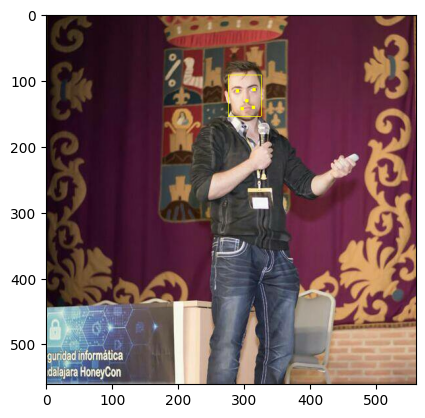

In [7]:
from mtcnn.utils.plotting import plot
import matplotlib.pyplot as plt

plt.imshow(plot(image, result))

As can be seen, the ONet is not only refining proposals by discarding those that do not match the thresholds and adjusting those that matched, but also proposing landmarks in the accepted bboxes.

### Accessing ONet's model

The network can be accessed by instantiating StageRNet and reading the attribute `model`, which is a TensorFlow model.

In [8]:
stage = StageONet()
model = stage.model

In [9]:
model.summary()

Model: "o_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu1 (PReLU)                  │ (None, 46, 46, 32)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling1 (MaxPooling2D)      │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu2 (PReLU)                  │ (None, 21, 21, 64)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling2 (MaxPooling2D)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu3 (PReLU)                  │ (None, 8, 8, 64)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling3 (MaxPooling2D)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 3, 3, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu4 (PReLU)                  │ (None, 3, 3, 128)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten4 (Flatten)              │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc5 (Dense)                     │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prelu5 (PReLU)                  │ (None, 256)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6-1 (Dense)                   │ (None, 4)              │         1,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6-2 (Dense)                   │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6-3 (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,040 (1.48 MB)

 Trainable params: 389,040 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

### Loading ONet's weights

The model weights are stored within the folder local `mtcnn/assets/weights/` under the filename `onet.lz4`. It can be loaded with `joblib`.

In [10]:
import joblib

onet_weights = joblib.load("../mtcnn/assets/weights/onet.lz4")

In [11]:
len(onet_weights)

21

In [12]:
[w.shape for w in onet_weights]

[(3, 3, 3, 32),
 (32,),
 (1, 1, 32),
 (3, 3, 32, 64),
 (64,),
 (1, 1, 64),
 (3, 3, 64, 64),
 (64,),
 (1, 1, 64),
 (2, 2, 64, 128),
 (128,),
 (1, 1, 128),
 (1152, 256),
 (256,),
 (256,),
 (256, 4),
 (4,),
 (256, 10),
 (10,),
 (256, 2),
 (2,)]

Further stage ablation can be performed by looking at `mtcnn/stages/stage_onet.py`